<!DOCTYPE html>
<html>
<head>
<title> <h1><center><span class="header-section-number"> 100. </span> Tensorflow 2.0.<br />
¿Qué es tf.keras realmente?<./h1></center></title>
</head>
<body>

</body>
</html>

<h2><span class="header-section-number"> 100.1 </span> Introducción </h2>

Este tutorial es una traducción del tutorial <a href="https://jaredwinick.github.io/what_is_tf_keras/">What is tf.keras really?</a> Todos los créditos deben ser dados a All  Jeremy Howard  y sus colaboradores Rachel Thomas and Francisco Ingham. Algunos modificaciones menores fueron hechas. La lectura de datos no la haremos directamente de la URL usada por los autores, porque el archivo fue movido de allí. Usaremos los datos disponible en *tf.keras.dataset*.

<h2><span class="header-section-number"> 100.1 </span> La base de datos MNIST </h2>

Utilizaremos el clásico conjunto de datos MNIST, que consiste en imágenes en blanco y negro de dígitos dibujados a mano (entre 0 y 9).

Para empezar importamos las librerías requeridas y se leen los datos de la base de datos. Luego se muestra la primera imágen de la base de datos usando las herramientas de Python. Cada imagen está almacenada en tamaño 28x28. son 60,000 imágenes de entrenamiento y 10,000 de validación.

In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals

import tensorflow as tf
print("Versión de Tensorflow: ", tf.__version__)

Versión de Tensorflow:  2.0.0


In [105]:
import matplotlib.pyplot as plt
import numpy as np

(x_train, y_train), (x_valid, y_valid) = tf.keras.datasets.mnist.load_data()
# resize x
x_train.resize((60000,784)) # Change shape and size of array in-place.
x_valid.resize((10000,784))


# transform x
x_train = tf.constant(x_train/255., dtype= tf.float32)
x_valid = tf.constant(x_valid/255., dtype= tf.float32)
print("shape x_train = ",x_train.shape)
print("type x_train = ",x_train.dtype)
print("Min x_train = ",tf.reduce_min(x_train).numpy())
print("Max x_train = ",tf.reduce_max(x_train).numpy())

# cast y
y_train = tf.constant(y_train,dtype=tf.int32)
y_valid = tf.constant(y_valid,dtype=tf.int32)
print("type y_train = ",y_train.dtype)
print("Min y_train = ",tf.reduce_min(y_train).numpy())
print("Max y_train = ",tf.reduce_max(y_train).numpy())


shape x_train =  (60000, 784)
type x_train =  <dtype: 'float32'>
Min x_train =  0.0
Max x_train =  1.0
type y_train =  <dtype: 'int32'>
Min y_train =  0
Max y_train =  9


In [3]:
%matplotlib inline

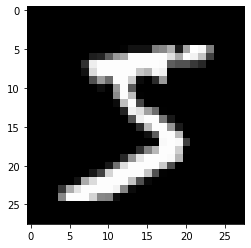

(60000, 784)
<class 'tensorflow.python.framework.ops.EagerTensor'>


In [4]:
plt.imshow(x_train[0].numpy().reshape((28,28)),cmap="gray")
plt.show()
print(x_train.shape)
print(type(x_train))

Estos datos tiene formato de arreglos numpy. Tensorflow utiliza el formato tf.Tensor, por lo que es necesario transformar los datos a dicho formato.  Usaremos la función *tf.Variable* para hacer la conversión. Note que se ha dividido x_train y x_valid entre 255, para trasnfprmar los datos a escala $[0.0,1.0]$. Si los datos no son transformados use *tf.constant*

<h2><span class="header-section-number"> 100.2 </span> La Red Neuronal desde cero (sin tf.keras) </h2>

Vamos a crear primero un modelo, para lo cual solamente usaremos las operacoones de Tensorflow.  Los pesos son inicializdos siguiendo la propuesta de <a href='http://proceedings.mlr.press/v9/glorot10a/glorot10a.pdf'>Gorot_Bengio </a>. Se generaran números aleatorios y se divide por $\sqrt{n}$. 
 

In [5]:
import math


weights = tf.Variable(tf.random.normal((784,10))/math.sqrt(784), dtype= tf.float32)
bias = tf.Variable(tf.zeros(10),tf.float32)


**Nota.** Tensorflow 2.0 incluye **diferenciación automática** para calcular gradientes automáticamente. Esto permite usar funciones estándar de Python como modelos para la redes. Vamos a crear un modeo lineal simple. Necesitaremos una función de activación, por lo que vamos a escribir la función *log_softmax*. La variable *eta* en la función, que corresponde al máximo de los valores, se introduce para tener una función muy robusta, desde el punto de vista computacional.

In [6]:
def log_softmax(x):
    eta = tf.math.reduce_max(x)
    return x -  tf.math.log(tf.math.reduce_sum(tf.math.exp(x), -1, keepdims=True))

def model(xb):
    return log_softmax(xb @ weights + bias)


En la celda anterior, el símbolo @ representa la operación del producto punto. Llamaremos a nuestra función con un lote de datos (en este caso, 64 imágenes). Este es un pase hacia adelante (forward pass). Tenga en cuenta que nuestras predicciones no serán mejores que aleatorias en esta etapa, ya que comenzamos con pesos aleatorios.


In [7]:
bs = 64 # batch size

xb = x_train[0:bs]
preds = model(xb) # predictions
print(preds[0], preds.shape)


tf.Tensor(
[-2.314689  -2.8350103 -2.671541  -2.3839228 -2.3984456 -2.5152397
 -1.8988264 -2.2424781 -1.962054  -2.1808972], shape=(10,), dtype=float32) (64, 10)


Vamos a implementar la función de log-verosimilitud negativa, la cual usaremos como **función de pérdida** (loss function). Esta es la misma **entropía cruzada**(cross entropy, usando la codificación One-hot)

In [8]:
def nll(input, target):
    indices = tf.stack([tf.range(input.shape[0], dtype=tf.int32),target], axis=1)
    return tf.math.reduce_mean(-tf.gather_nd(input, indices))

loss_func = nll


Sobre el código anterior. 
1. *tf.range(input.shape[0])*  genera un tensor con números en el rango entre 0 1 63, porque la forma (shape) es 64, el tamaño del batch.
2. *tf.stack([tf.range(input.shape[0], dtype=tf.int64),target], axis=1)* crea un tensor bidimensional, en donde cada fila corresponde al índice del elemento que debe tomarse de cada fila de input para calcualr la funcion de párdida. Por ejemplo, si la fila 3 de índice es [3,4], significará que y_train[3] es 4, y ṕor tanto se requiere tomar el contenido de la cuarta posición de la entrada 3.
3. tf.gather_nd(input, indices). Para cada fila de input toma el valor de input en la posición indicada en el índice, como se explica en el numeral 2.
4. tf.math.reduce_mean(-tf.gather_nd(input, indices)), calcula el resumen. La media, que corresponde exáctamete a - log likelihood

Revisamos ahora la **función de pérdida** para el modelo con datos aleatorios. Esto permitirá comparar las mejorsa después del paso de propagacion hacia atrás  (backpropagation)

In [9]:
yb = y_train[0:bs]
print(loss_func(preds,yb))

tf.Tensor(2.434606, shape=(), dtype=float32)


También implementamos la función precisión (accuracy) de nuestro modelo.

In [10]:
def accuracy(out,yb):
    preds = tf.dtypes.cast(tf.math.argmax(out,axis=1), tf.int32)   # posición del valor máximo en cada arreglo
    return tf.math.reduce_mean(tf.dtypes.cast(preds==yb,tf.float16))


chequamos la precisión actual del modelo

In [11]:
print(accuracy(preds,yb))

tf.Tensor(0.1562, shape=(), dtype=float16)


 Estamos listos para correr el ciclo de entranamiento. Para calcular los gradientes usaremos diferenciación automática, con la clase tf.GradientTape.
 
- Seleccionamos un mini-batch de datos de tamaño *bs*
- Bajo un contexto tf.GradientTape 
 - Usamos el modelo para hacer predicciones
 - Calculamos la pérdida
- Calculamos el gradientes de las operaciones registradas en el contexto de esta cinta (tape).

Ahora usamos estos gradientes para actualizar los pesos (weights) y los desplazamientos (bias).


In [12]:
lr = 0.2 # learning rate
epochs = 2 # how many epochs to train for
n = x_train.shape[0]

for epoch in range(epochs):
    for i in range((n-1)//bs +1):
        start_i = i*bs
        end_i = start_i + bs
        xb = x_train[start_i:end_i]
        yb = y_train[start_i:end_i]
        with tf.GradientTape() as t:
            pred = model(xb)
            loss = loss_func(pred,yb)
        dW, dB = t.gradient(loss,[weights,bias])
        weights.assign_sub(lr*dW)
        bias.assign_sub(lr*dB)


Hemos creado y entrenado una red neuronal minimal( en este caso una regression logística, dado que no tiene capas ocultas) totalmwente desde cero (from scratch).

Revisemos la pérdida y precisión del modelo.

In [13]:
print(loss_func(model(xb),yb))
print(accuracy(model(xb),yb))

tf.Tensor(0.09764923, shape=(), dtype=float32)
tf.Tensor(0.9688, shape=(), dtype=float16)


<h2><span class="header-section-number"> 100.2 </span> La Red Neuronal usando tf.keras</h2>

Ahora refactorizaremos nuestro código, para que haga lo mismo que antes, solo que comenzaremos a aprovechar las clases *tf.keras* de TensorFlow para hacerlo más conciso y flexible. En cada paso a partir de aquí, deberíamos hacer que nuestro código sea más corto, más comprensible y / o más flexible.

El primer y más fácil paso es acortar nuestro código reemplazando nuestras funciones de activación y pérdida escritas a mano con las de tf.keras.

TensorFlow proporciona una función única función *tf.keras.losses.SparseCategoricalCrossentropy* que combina una activación softmax con una función de pérdida. Tenga en cuenta que usamos from_logit = True aquí porque no estamos pasando una distribución de probabilidad

In [14]:
loss_func = tf.keras.losses.SparseCategoricalCrossentropy(from_logits = True)

def model(xb):
    return xb @ weights + bias


In [15]:
print(loss_func(yb,model(xb)), accuracy(model(xb),yb))

tf.Tensor(0.09764923, shape=(), dtype=float32) tf.Tensor(0.9688, shape=(), dtype=float16)


<h2><span class="header-section-number"> 100.3 </span> Refactorización usando tf.keras.Model </h2>

A continuación, utilizaremos *tf.keras.Model* para un ciclo de entrenamiento más claro y conciso. Hacemos una subclase (heredamos) de la clase *tf.keras.Model* (que en sí mismo es una clase y puede realizar un seguimiento del estado). En este caso, queremos crear una clase que contenga nuestros pesos, sesgos y métodos para el paso adelante (forward pass).

In [16]:
class Mnist_logistic(tf.keras.Model):
    def __init__(self):
        super(Mnist_logistic,self).__init__()
        self.w = tf.Variable(tf.random.normal((784,10)) /math.sqrt(784))
        self.b = tf.Variable(tf.zeros(10))
    
    def call(self, xb):
        return xb @ self.w + self.b
    

Como ahora estamos usando un objeto en lugar de solo usar una función, primero tenemos que instanciar nuestro modelo:

In [17]:
model = Mnist_logistic()

Ahora podemos calcular la pérdida de la misma manera que antes. Tenga en cuenta que los objetos *tf.keras.Model* se usan como si fueran funciones (es decir, son invocables), pero detrás de escena TensorFlow llamará a nuestro método *call* automáticamente.

In [18]:
print(loss_func(yb,model(xb)))

tf.Tensor(2.2851243, shape=(), dtype=float32)


In [75]:
def fit():
    for epoch in range(epochs):
        for i in range((n-1)//bs +1):
            start_i = i*bs
            end_i = start_i + bs
            xb = x_train[start_i:end_i]
            yb = y_train[start_i:end_i]
            with tf.GradientTape() as t:
                pred = model(xb)
                loss = loss_func(yb, pred)
                
            gradients = t.gradient(loss, model.trainable_variables)
            for variable, grad in zip(model.trainable_variables, gradients):
                variable.assign_sub(lr * grad)
                
            

In [76]:
fit()

Chequeemos que la  pérdida ha descendido

In [80]:
print(loss_func(yb,model(xb)), accuracy(model(xb),yb))

tf.Tensor(0.06662762, shape=(), dtype=float32) tf.Tensor(0.9688, shape=(), dtype=float16)


In [81]:
xb.shape

TensorShape([32, 784])

<h2><span class="header-section-number"> 100.3 </span> Refactorización usando tf.keras.layers.Dense </h2>

Continuamos refactorizando nuestro código. En lugar de definir e inicializar manualmente *self.weights* y *self.bias*, y calcular *xb @ self.weights + self.bias*, en su lugar usaremos la clase TensorFlow *tf.keras.layers.Dense* para una capa lineal, que hace todo eso por nosotros. TensorFlow tiene muchos tipos de capas predefinidas que pueden simplificar enormemente nuestro código y, a menudo, también lo hacen más rápido.

In [91]:
class Mnist_Logistic(tf.keras.Model):
    def __init__(self):
        super(Mnist_Logistic,self).__init__()
        self.linear = tf.keras.layers.Dense(10, input_shape=(None,784))
        
    def call(self, xb):
        return self.linear(xb)
    

Instanciamos el modelo y calculamos la pérdida inicial, como antes.

In [92]:
model = Mnist_Logistic()
print(loss_func(yb, model(xb)))

tf.Tensor(2.36521, shape=(), dtype=float32)


Aun podemos usar el método fit como antes

In [93]:
fit()

print(loss_func(yb, model(xb)))

tf.Tensor(0.09545911, shape=(), dtype=float32)


<h2><span class="header-section-number"> 100.3 </span> Refactorización usando tf.keras.optimizers </h2>

TensorFlow también tiene un paquete con varios algoritmos de optimización, *tf.keras.optimizers*. Podemos usar el método *apply_gradients* de nuestro optimizador para avanzar, en lugar de actualizar manualmente cada parámetro.

Reeeplazaremos el fragmento de código

    for variable, grad in zip(model.trainable_variables, gradients):
        variable.assign_sub(lr * grad)

por

    opt.apply_gradients(zip(gradients, model.trainable_variables))
 
 Usaremos stochastic Gradient Descent (SGD)

In [99]:
def get_model():
    model = Mnist_Logistic()
    return model, tf.keras.optimizers.SGD(lr=lr)

model, opt = get_model()
print(loss_func(yb,model(xb)))

for epoch in range(epochs):
    for i in range((n-1) // bs + 1):
        start_i = i*bs
        end_i   = start_i + bs
        xb  = x_train[start_i:end_i]
        yb  = y_train[start_i:end_i]
        
        with tf.GradientTape() as t:
            pred = model(xb)
            loss = loss_func(yb, pred)
        gradients = t.gradient(loss, model.trainable_variables)
        opt.apply_gradients(zip(gradients,model.trainable_variables))

print(loss_func(yb,model(xb)))

tf.Tensor(2.3960228, shape=(), dtype=float32)
tf.Tensor(0.09480931, shape=(), dtype=float32)


<h2><span class="header-section-number"> 100.4 </span> Refactorización usando Dataset</h2>

TensorFlow proporciona la clase *tf.data.Dataset* como una abstracción sobre los datos necesarios para las tuberías de aprendizaje automático. Una manera simple de construir un conjunto de datos es a partir de los tensores existentes. El conjunto de datos puede contener tanto la entrada como las etiquetas, y también proporciona una manera fácil de iterar sobre lotes. 

In [101]:
train_ds = tf.data.Dataset.from_tensor_slices((x_train,y_train))

Previamente hemos itrado los lotes (batches) de datos usando el código

    for i in range((n-1) // bs + 1):
        start_i = i*bs
        end_i   = start_i + bs
        xb  = x_train[start_i:end_i]
        yb  = y_train[start_i:end_i]

Ahora lo reescribiremos como

    for xb, yb in train_ds.batch(bs):

In [102]:
model, opt = get_model()

for epoch in range(epochs):
    for xb, yb in train_ds.batch(bs):
        with tf.GradientTape() as t:
            pred = model(xb)
            loss = loss_func(yb,pred)
        gradients = t.gradient(loss, model.trainable_variables)
        opt.apply_gradients(zip(gradients, model.trainable_variables))

print(loss_func(yb, model(xb)))

tf.Tensor(0.10288866, shape=(), dtype=float32)


Gracias a *tf.keras.Model*, *tf.keras.optimizers*, y *tf.data.Dataset*, nuestro código ahora es dramáticamente más corto y fácil de entender que al comienzo.

<h2><span class="header-section-number"> 100.5 </span> Agregando Validación</h2>

Desde el comienzo hemos reservado un conjunto de datos para validar nuestro modelo: x_valid y y_valid, con el propósito de identificar sobreajuste (overfitting)

Mezclar (shuffling) los datos de entrenamiento es importante para evitar la correlación entre lotes y sobreajuste. Por otro lado, la pérdida de validación será idéntica si barajamos (we shuffle) el conjunto de validación o no. Como barajar toma tiempo adicional, no tiene sentido barajar los datos de validación.

Utilizaremos un tamaño de lote para el conjunto de validación que es dos veces más grande que el del conjunto de entrenamiento. Esto se debe a que el conjunto de validación no necesita propagación hacia atrás y, por lo tanto, requiere menos memoria (no necesita almacenar los gradientes). Aprovechamos esto para usar un tamaño de lote más grande y calcular la pérdida más rápidamente.


In [107]:
SHUFFLE_BUFFER_SIZE = 100

train_ds = tf.data.Dataset.from_tensor_slices((x_train, y_train)).shuffle(SHUFFLE_BUFFER_SIZE).batch(bs)
validation_ds = tf.data.Dataset.from_tensor_slices((x_valid,y_valid)).batch(bs*2)

Calcularemos e imprimiremos la pérdida y precisión de entrenamiento y validación al final de cada periodo (epoch). Para hacer esto, aprovecharemos el módulo *tf.keras.metrics*.

In [114]:
model, opt = get_model()

train_loss = tf.keras.metrics.Mean(name='train_loss')
train_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='train_accuracy')

validation_loss = tf.keras.metrics.Mean(name='validation_loss')
validation_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='validation_accuracy')

for epoch in range(epochs):
    for xb, yb in train_ds:
        with tf.GradientTape() as t:
            pred = model(xb)
            loss = loss_func(yb,pred)
            
            gradients = t.gradient(loss, model.trainable_variables)
            opt.apply_gradients(zip(gradients, model.trainable_variables))
            
            train_loss(loss)
            train_accuracy(yb, pred)
    
    for xb, yb in validation_ds:
        pred = model(xb)
        loss = loss_func(yb, pred)
        
        validation_loss(loss)
        validation_accuracy(yb, pred)
        
    # From https://www.tensorflow.org/tutorials/quickstart/advanced
    template = 'Epoch {}, Loss: {}, Accuracy: {}, Valid Loss: {}, Valid Accuracy: {}'
    print(template.format(epoch+1,
                         train_loss.result(),
                         train_accuracy.result()*100,
                         validation_loss.result(),
                         validation_accuracy.result()*100))
    
    # reset the metrics for the next epoch
    train_loss.reset_states()
    train_accuracy.reset_states()
    validation_loss.reset_states()
    validation_accuracy.reset_states()
        

Epoch 1, Loss: 0.4139716625213623, Accuracy: 88.62166595458984, Valid Loss: 0.32240140438079834, Valid Accuracy: 90.51000213623047
Epoch 2, Loss: 0.3126678168773651, Accuracy: 91.23999786376953, Valid Loss: 0.2951362431049347, Valid Accuracy: 91.57999420166016


<h2><span class="header-section-number"> 100.6 </span> Mejorando la función fit()</h2>

Ahora haremos una pequeña refactorización propia. Dado que pasamos por un proceso similar dos veces de calcular la pérdida tanto para el conjunto de entrenamiento como para el conjunto de validación, hagámoslo en su propia función, *loss_batch*, que calcula la pérdida para un lote.

Pasamos un optimizador para el conjunto de entrenamiento y lo usamos para realizar backprop. Para el conjunto de validación, no pasamos un optimizador, por lo que el método no realiza backprop


In [122]:
def loss_batch(model, loss_func, xb, yb, metric_loss, metric_accuracy, opt=None):
    with tf.GradientTape() as t:
        pred = model(xb)
        loss = loss_func(yb,pred)
        
    if opt is not None:
        gradients = t.gradient(loss, model.trainable_variables)
        opt.apply_gradients(zip(gradients,model.trainable_variables))
        
    metric_loss(loss)
    metric_accuracy(yb, pred)
    return loss, len(xb)



la función fit queda ahora asi:


In [120]:
def fit(epochs, model, loss_func, opt, train_ds, valid_ds):
    train_loss = tf.keras.metrics.Mean(name='train_loss')
    train_accuray = tf.keras.metrics.SparseCategoricalAccuracy(name='train_accuracy')
    
    validation_loss = tf.keras.metrics.Mean(name='validation_loss')
    validation_accuray = tf.keras.metrics.SparseCategoricalAccuracy(name='validation_accuracy')
    
    for epoch in range(epochs):
        for xb, yb in train_ds:
            loss_batch(model, loss_func, xb, yb, train_loss, train_accuracy, opt)
         
        for xb, yb in valid_ds:
            loss_batch(model, loss_func, xb, yb, validation_loss, validation_accuracy)
        
        template = 'Epoch {}, Loss: {}, Accuracy: {}, Valid Loss: {}, Valid Accuracy: {}'
        print(template.format(epoch+1,
                         train_loss.result(),
                         train_accuracy.result()*100,
                         validation_loss.result(),
                         validation_accuracy.result()*100))
    
        # reset the metrics for the next epoch
        train_loss.reset_states()
        train_accuracy.reset_states()
        validation_loss.reset_states()
        validation_accuracy.reset_states()

Ahora corremos todo el proceso de ajuste (fitting) del modelo. Solamente requerimos dos líneas

In [123]:
model, opt = get_model()
fit(epochs, model, loss_func, opt, train_ds, validation_ds)

Epoch 1, Loss: 0.41325464844703674, Accuracy: 88.68000030517578, Valid Loss: 0.3169042468070984, Valid Accuracy: 91.0199966430664
Epoch 2, Loss: 0.3123631477355957, Accuracy: 91.28999328613281, Valid Loss: 0.2999750077724457, Valid Accuracy: 91.32999420166016


<h2><span class="header-section-number"> 100.7 </span> Cambiando a una red neuronal convolucionada (CNN)</h2>

Ahora vamos a construir nuestra red neuronal con una capa convolucional. Debido a que ninguna de las funciones en la sección anterior asume nada sobre la forma del modelo, podremos usarlas para entrenar un CNN sin ninguna modificación.

Utilizaremos la clase *tf.keras.layers.Conv2D* predefinida de TensorFlow como nuestra capa convolucional. Definimos un CNN con 1 capa convolucional.

In [132]:
class Mnist_CNN(tf.keras.Model):
    def __init__(self):
        super(Mnist_CNN, self).__init__()
        self.reshape1 = tf.keras.layers.Reshape((28,28,1), input_shape=((784,)))
        self.conv1 = tf.keras.layers.Conv2D(32, kernel_size=3, strides=2, activation='relu')
        self.flatten = tf.keras.layers.Flatten()
        self.d1 = tf.keras.layers.Dense(128, activation='relu')
        self.d2 = tf.keras.layers.Dense(10, activation='softmax')
        
    def call(self, xb):
        xb = self.reshape1(xb)
        xb = self.conv1(xb)
        xb = self.flatten(xb)
        xb = self.d1(xb)
        return self.d2(xb)
        
    

In [133]:
model = Mnist_CNN()
opt = tf.keras.optimizers.Adam()
loss_func = tf.keras.losses.SparseCategoricalCrossentropy()

fit(epochs, model, loss_func, opt, train_ds, validation_ds)


Epoch 1, Loss: 0.21882613003253937, Accuracy: 93.76166534423828, Valid Loss: 0.10195889323949814, Valid Accuracy: 96.66999816894531
Epoch 2, Loss: 0.07251006364822388, Accuracy: 97.84667205810547, Valid Loss: 0.07027331739664078, Valid Accuracy: 97.73999786376953


<h2><span class="header-section-number"> 100.8 </span> tf.keras.Sequential</h2>

*tf.keras* tiene otra clase útil que podemos usar para simplemente nuestro código *tf.keras.Sequential*. Un objeto secuencial ejecuta cada uno de los módulos contenidos en él, de manera secuencial. Esta es una forma más simple de escribir nuestra red neuronal.

El modelo creado con secuencial es simplemente:

In [134]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Reshape((28,28,1), input_shape=((784,))),
    tf.keras.layers.Conv2D(32, kernel_size=3, strides=2, activation='relu'),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(10, activation='softmax')])

opt = tf.keras.optimizers.Adam()

fit(epochs, model, loss_func, opt, train_ds, validation_ds)

Epoch 1, Loss: 0.23225533962249756, Accuracy: 93.32666015625, Valid Loss: 0.11613459885120392, Valid Accuracy: 96.34000396728516
Epoch 2, Loss: 0.07633589953184128, Accuracy: 97.66500091552734, Valid Loss: 0.06803903728723526, Valid Accuracy: 97.81999969482422


<h2><span class="header-section-number"> 100.9 </span> Usando la función pre-construida fit</h2>



In [136]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Reshape((28,28,1), input_shape=((784,))),
    tf.keras.layers.Conv2D(32,kernel_size=3, strides = 2, activation='relu'),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(10,activation='softmax')])

In [139]:
model.compile(optimizer='adam',
              loss ='sparse_categorical_crossentropy',
              metrics =['accuracy'])
model.fit(train_ds, epochs =2)
model.evaluate(validation_ds)

Epoch 1/2
938/938 [==============================] - 29s 31ms/step - loss: 0.2120 - accuracy: 0.9402
Epoch 2/2
79/79 [==============================] - 1s 16ms/step - loss: 0.0696 - accuracy: 0.9768


[0.06963293598537464, 0.9768]